In [ ]:
%pip uninstall numpy -y
%pip install numpy==1.26.4


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.47.2 requires huggingface-hub<2.0,>=0.33.5, but you have huggingface-hub 0.25.1 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
retinalysis-fundusprep 0.5.1 requires numpy==2.*, but you have numpy 1.26.4 which is incompatible.
retinalysis-fundusprep 0.5.1 requires Pillow==11.*, but you have pillow 9.5.0 which is incompatible.
retinalysis-fundusprep 0.5.1 requires pydicom==3.*, but you have pydicom 2.3.1 which is incompatible.
retinalysis-inference 0.3.0 requires numpy==2.*, but you have numpy 1.26.4 which is incompatible.
salib 1.5.2 requires numpy>=2.0, but you have numpy 1.26

In [84]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
file_path = '/content/drive/MyDrive/yoga/Yoga Dataset'

In [8]:
#set random seed
tf.random.set_seed(42)

In [9]:
#set image size & batch size
image_size = (224, 224)
batch_size = 32

In [10]:
#image datagenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
    ,validation_split=0.2,
)

train_gen = train_datagen.flow_from_directory(
    file_path, target_size=image_size,
    batch_size=batch_size, class_mode='categorical',
    subset='training', shuffle=True)

val_gen = train_datagen.flow_from_directory(
    file_path, target_size=image_size,
    batch_size=batch_size, class_mode='categorical',
    subset='validation', shuffle=False)

Found 1045 images belonging to 4 classes.
Found 259 images belonging to 4 classes.


<Figure size 1200x500 with 0 Axes>

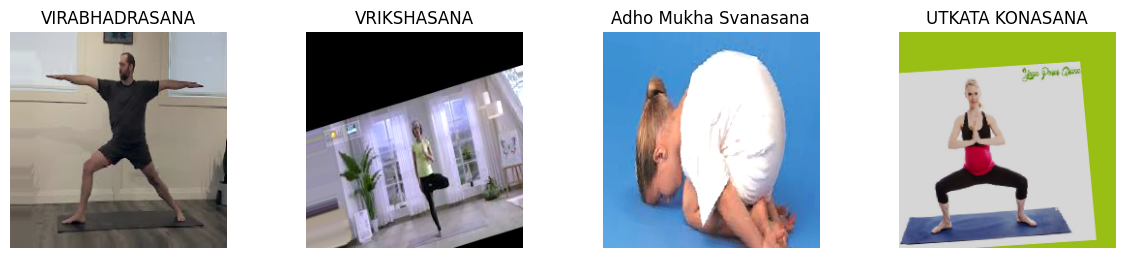

In [11]:
#show images of each class
images, labels = next(train_gen)
class_names = list(train_gen.class_indices.keys()) #class names from the generator

images_per_class = {} #empty dict to store images per class
plt.figure(figsize = (12, 5))
for i in range (images.shape[0]):
    predicted_class_index = np.argmax(labels[i]) #get the index of the class with highest probability
    predicted_class = class_names[predicted_class_index] #get the class name from the index
    if predicted_class not in images_per_class:
        images_per_class[predicted_class] = images[i] #if class not in dict, add it

    if len(images_per_class) == len(class_names):
            break

plt.figure(figsize=(12, 5))
i = 1
for class_name, image in images_per_class.items():
    plt.subplot(2, len(images_per_class), i)
    if image.shape[-1] == 1:
        # Grayscale to RGB
        image = np.squeeze(image)
        plt.imshow(image, cmap='gray')
    else:
        # RGB: rescale if needed
        plt.imshow((image * 255).astype("uint8"))
    plt.title(class_name)
    plt.axis('off')
    i += 1
plt.tight_layout()
plt.show()


## **Baseline Model**

In [71]:
#Train model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3), use_bias=False),
    layers.Conv2D(32, (3, 3), activation='relu', use_bias=False),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', use_bias=False),
    layers.Conv2D(64, (3, 3), activation='relu', use_bias=False),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

#compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [72]:
#model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 220, 220, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 108, 108, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 106, 106, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 106, 106, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,596 (291.39 KB)

 Trainable params: 74,404 (290.64 KB)

 Non-trainable params: 192 (768.00 B)

In [73]:
#train model
with tf.device('/device:GPU:0'):
  history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10
    )

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3750 - loss: 1.3578 - val_accuracy: 0.2587 - val_loss: 1.6130
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 994ms/step - accuracy: 0.4341 - loss: 1.2795 - val_accuracy: 0.2973 - val_loss: 1.6041
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4753 - loss: 1.2293 - val_accuracy: 0.2703 - val_loss: 2.0276
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 912ms/step - accuracy: 0.4713 - loss: 1.2301 - val_accuracy: 0.3861 - val_loss: 1.2721
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 919ms/step - accuracy: 0.4730 - loss: 1.2133 - val_accuracy: 0.4479 - val_loss: 1.2888
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4778 - loss: 1.2156 - val_accuracy: 0.4556 - val_loss: 1.4444
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 933ms/step - accuracy: 0.5181 - loss: 1.1656 - val_accuracy: 0.4363 - val_loss: 4.3419
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 952ms/step - accuracy: 0.4266 - loss: 1.2409 - val_accuracy: 0.3

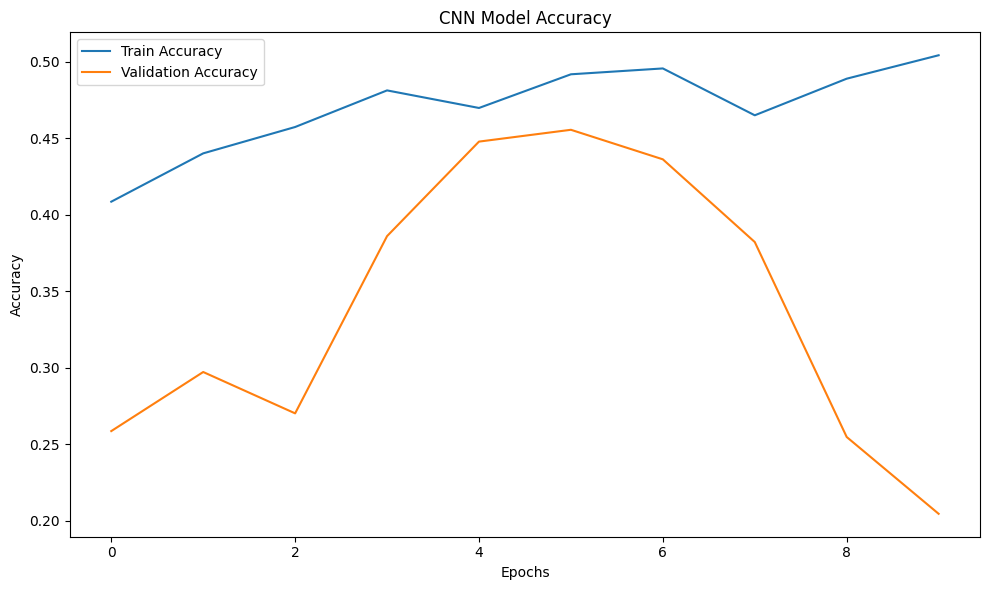

In [74]:
#plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## **Transfer Learning Model- MobileNetV2**

In [85]:
#Transfer learning model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

tl_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

#compile transfer learning model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
tl_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
#model summary
tl_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [86]:
with tf.device('/GPU:0'):
    tl_history = tl_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30
    )

Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.4554 - loss: 1.3397 - val_accuracy: 0.8185 - val_loss: 0.6222
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 965ms/step - accuracy: 0.7453 - loss: 0.6975 - val_accuracy: 0.8456 - val_loss: 0.4504
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8267 - loss: 0.5316 - val_accuracy: 0.8803 - val_loss: 0.3816
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 68s 880ms/step - accuracy: 0.8649 - loss: 0.4145 - val_accuracy: 0.8842 - val_loss: 0.3236
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 984ms/step - accuracy: 0.8796 - loss: 0.3877 - val_accuracy: 0.8919 - val_loss: 0.3209
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 915ms/step - accuracy: 0.8864 - loss: 0.3333 - val_accuracy: 0.8880 - val_loss: 0.3494
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 882ms/step - accuracy: 0.8755 - loss: 0.3413 - val_accuracy: 0.9073 - val_loss: 0.2881
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 870ms/step - accuracy: 0.8881 - loss: 0.3181 - val_accuracy: 

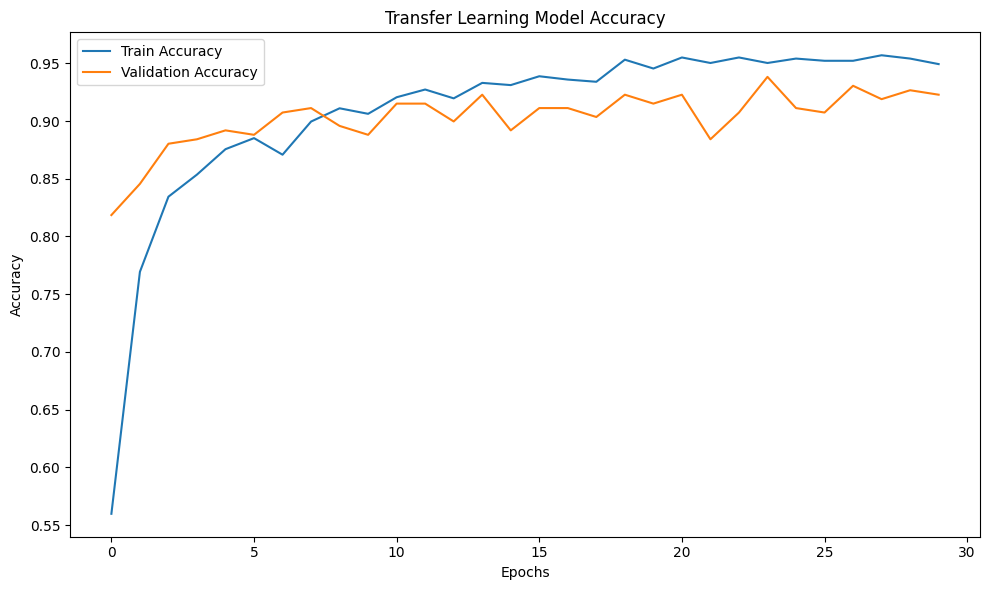

In [87]:
#plot training history
plt.figure(figsize=(10, 6))
plt.plot(tl_history.history['accuracy'], label='Train Accuracy')
plt.plot(tl_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## **Local Interpretable Model-agnostic Explainability (LIME)**

In [75]:
%pip install lime

In [88]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [99]:
img = x_batch[2]
img_uint8 = (img * 255).astype("uint8")

In [100]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    img_uint8,
    classifier_fn=lambda x: tl_model.predict(x/255.0),   # normalize inside prediction
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


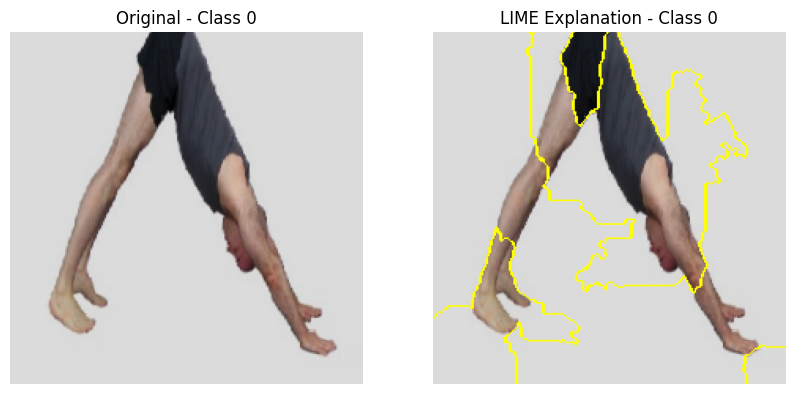

In [101]:
pred_label = np.argmax(tl_model.predict(img[np.newaxis, ...]))

temp, mask = explanation.get_image_and_mask(
    pred_label,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img_uint8)
ax[0].set_title(f"Original - Class {true_label}")
ax[0].axis("off")

ax[1].imshow(mark_boundaries(temp, mask))
ax[1].set_title(f"LIME Explanation - Class {pred_label}")
ax[1].axis("off")

plt.show()

## **Shapely Additive exPlainability (SHAP)**

In [80]:
!pip install shap

In [81]:
import shap

In [102]:
explainer = shap.GradientExplainer(tl_model, baseline)
shap_values = explainer.shap_values(img_input)
heatmap = shap_values[0][0].mean(axis=-1)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

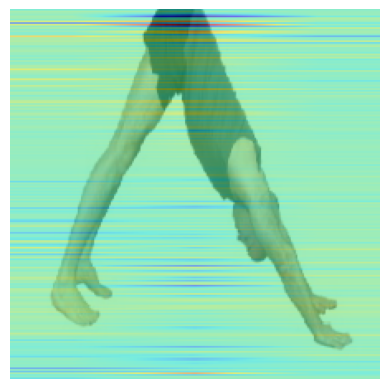

In [103]:
import cv2
heatmap_up = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
plt.imshow((img*255).astype("uint8"))
plt.imshow(heatmap_up, cmap='jet', alpha=0.5)
plt.axis("off")